In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
def split_train_test(datax, datay, data, n_steps):
	X, y = [], []
	for i in range(n_steps, len(data)):
		X.append(datax[i-n_steps:i])
		y.append(datay[i])
	return np.array(X), np.array(y)

In [3]:
def Xtrain_ytrain(train,test,n_steps):
    sc = MinMaxScaler()
    train_x = sc.fit_transform(train)
    sc1 = MinMaxScaler()
    train_y = sc1.fit_transform(train[['cloud_cover']])
    # train
    X_train, y_train = split_train_test(train_x,train_y, train, n_steps)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    columns = test[['Eeg','Temperature','RH','Windspeed','cloud_cover']]
    dataset_total = pd.concat(([train,test]), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - n_steps:].values
    inputs = pd.DataFrame(inputs, columns=columns.columns)
    test_x = sc.transform(inputs)
    test_y = sc1.transform(inputs[['cloud_cover']])
    # test
    X_test, y_test = split_train_test(test_x,test_y, inputs, n_steps)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc1

In [4]:
def plot_curve(history):
    print('Last train loss: %s'%history.history['loss'][-1])
    print('Last validation loss: %s'%history.history['val_loss'][-1])
    
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    fig = plt.figure(figsize=[8,6])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'orange', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend() 

In [5]:
def compare_mse_model(model,model_1):
    mse_error = [model,model_1]
    error = pd.DataFrame({"Model" : ['model','model_1'], "MSE error": mse_error})
    return error

In [6]:
df = pd.read_csv('../succeed-prophet/mergefile_drop_na.csv',skipinitialspace = True)
df

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


# Train/Test Model

In [7]:
train = df[df['timestamp'] < '2021-12-16 00:00:00']
test = df[df['timestamp'] >= '2021-12-16 00:00:00']

train = train.set_index('timestamp')
test = test.set_index('timestamp')

print('train Shape', train.shape)
print('test Shape', test.shape)

train Shape (2921, 5)
test Shape (59, 5)


In [8]:
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,30)

X_train Shape : (2891, 30, 5)
y_train Shape : (2891, 1)
X_test Shape :  (59, 30, 5)
y_test Shape :  (59, 1)


## Add frist layer: units = 50

In [9]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [10]:
hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 5s 22ms/step - loss: 0.0385 - accuracy: 0.0093 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0129 - accuracy: 0.0093 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0104 - accuracy: 0.0093 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0089 - accuracy: 0.0093 - val_loss: 0.0155 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 0.0093 - val_loss: 0.0144 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 1s 14ms/step - loss: 0.0071 - accuracy: 0.0093 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 2s 20ms/step - loss: 0.0068 - accuracy: 0.0093 - val_loss: 0.0121 - val_accura

Last train loss: 0.004817612003535032
Last validation loss: 0.009821124374866486


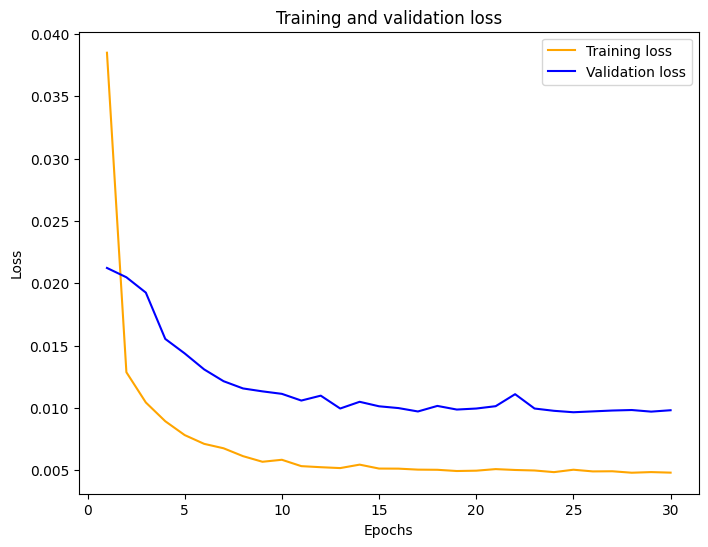

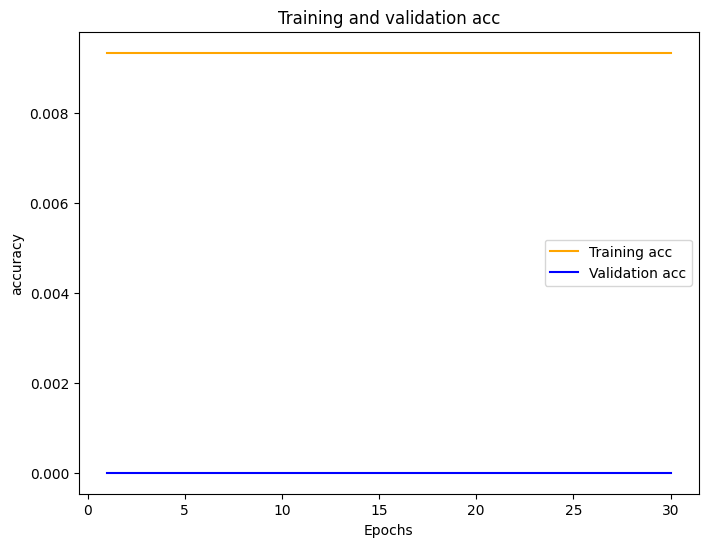

In [11]:
plot_curve(hist)

In [12]:
predict_scaled = regressor.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

2/2 [==============================] - 1s 6ms/step


array([[0.14950033],
       [0.09974388],
       [0.11043564],
       [0.11972312],
       [0.13459784],
       [0.15930206],
       [0.16175154],
       [0.15844677],
       [0.19740957],
       [0.26811334],
       [0.34415025],
       [0.32799414],
       [0.3005355 ],
       [0.26141366],
       [0.3003568 ],
       [0.3273736 ],
       [0.4479106 ],
       [0.32391882],
       [0.57561857],
       [0.69836223],
       [0.7392302 ],
       [0.78598076],
       [0.29314968],
       [0.21267058],
       [0.20786847],
       [0.17053436],
       [0.18329953],
       [0.17409933],
       [0.17293112],
       [0.16223074],
       [0.16283835],
       [0.15372331],
       [0.14167319],
       [0.13789785],
       [0.16110316],
       [0.17101105],
       [0.17543197],
       [0.17285258],
       [0.17790978],
       [0.17193234],
       [0.17490791],
       [0.16999446],
       [0.15267842],
       [0.16470791],
       [0.175367  ],
       [0.18020383],
       [0.17984948],
       [0.174

In [13]:
test['LSTM'] = predict
test.reset_index(inplace=True)
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113


In [14]:
train.reset_index(inplace=True)
train

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2917,2021-12-15 16:40:00,182.6936,29.6908,56.1350,1.6476,0.214000
2918,2021-12-15 16:45:00,165.2176,29.6822,56.8298,1.7884,0.311000
2919,2021-12-15 16:50:00,147.5764,29.5512,57.3708,1.6884,0.250000
2920,2021-12-15 16:55:00,122.0440,29.5322,57.3102,1.7668,0.321000


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [16]:
lstm_mse_error_unit_50 = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM'])
print()
print(f'MSE Error: {lstm_mse_error_unit_50}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.009330478373804156
RMSE Error: 0.09659440135848535
MAE: 0.0448959945573889
r2_score: 0.5942135966782787


----------------------------------------------------------------------------------

## Add frist layer: units = 100

In [17]:
regressor_1 = Sequential()
regressor_1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_1.add(Dense(units = 1))
regressor_1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [18]:
hist_1 = regressor_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 7s 43ms/step - loss: 0.0298 - accuracy: 0.0090 - val_loss: 0.0202 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 2s 23ms/step - loss: 0.0123 - accuracy: 0.0093 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 2s 24ms/step - loss: 0.0101 - accuracy: 0.0093 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 3s 28ms/step - loss: 0.0086 - accuracy: 0.0093 - val_loss: 0.0150 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0073 - accuracy: 0.0093 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0067 - accuracy: 0.0093 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 2s 24ms/step - loss: 0.0059 - accuracy: 0.0093 - val_loss: 0.0114 - val_accura

Last train loss: 0.0049135214649140835
Last validation loss: 0.008995632641017437


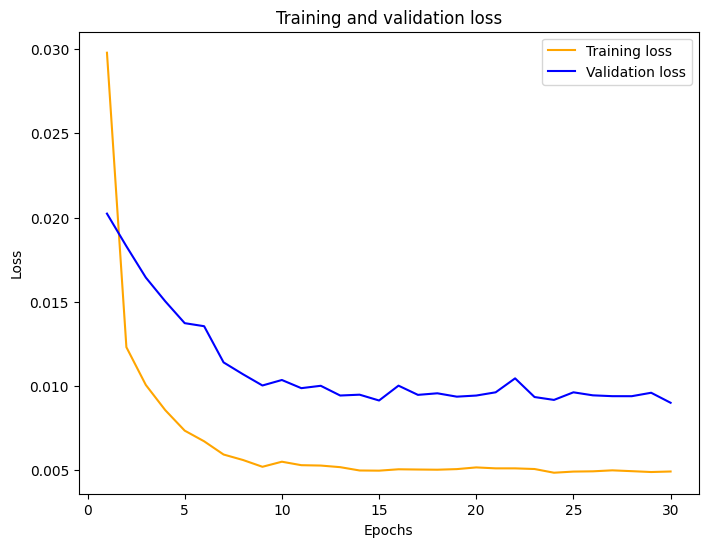

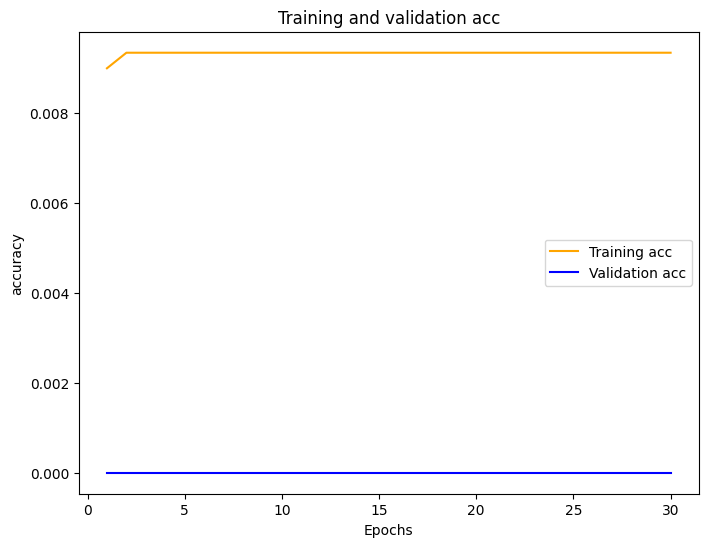

In [19]:
plot_curve(hist_1)

In [20]:
predict_scaled_1 = regressor_1.predict(X_test)
predict_1 = sc.inverse_transform(predict_scaled_1)
predict_1

2/2 [==============================] - 1s 7ms/step


array([[0.14891098],
       [0.10327626],
       [0.11753139],
       [0.12606567],
       [0.13868433],
       [0.16525717],
       [0.16414683],
       [0.15893398],
       [0.19924141],
       [0.2683164 ],
       [0.3424159 ],
       [0.3223654 ],
       [0.29269922],
       [0.25535035],
       [0.2953196 ],
       [0.320944  ],
       [0.43923676],
       [0.31621692],
       [0.5640435 ],
       [0.6850741 ],
       [0.72304827],
       [0.76526666],
       [0.27832678],
       [0.20049702],
       [0.1957928 ],
       [0.16199279],
       [0.17329732],
       [0.16570571],
       [0.16504975],
       [0.15521337],
       [0.15616363],
       [0.14679885],
       [0.13416052],
       [0.1298572 ],
       [0.15243083],
       [0.16119802],
       [0.16342881],
       [0.1610711 ],
       [0.16485396],
       [0.15881631],
       [0.1609322 ],
       [0.15498355],
       [0.13960317],
       [0.15069468],
       [0.16214743],
       [0.16658609],
       [0.16624834],
       [0.161

In [21]:
test['LSTM_1'] = predict_1
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_1'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [23]:
lstm_mse_error_unit_100 = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_1'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_1'])
print()
print(f'MSE Error: {lstm_mse_error_unit_100}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.00890590164420171
RMSE Error: 0.09437108478873023
MAE: 0.040453315162453166
r2_score: 0.6126786160628348


In [24]:
compare_mse_model(lstm_mse_error_unit_50,lstm_mse_error_unit_100)

,Model,MSE error
0,model,0.009330
1,model_1,0.008906


------------

## Add frist layer: units = 50 and Add Dropout = 0.1

In [25]:
regressor_2 = Sequential()
regressor_2.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_2.add(Dropout(0.1))
regressor_2.add(Dense(units = 1))
regressor_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [26]:
hist_2 = regressor_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 9s 45ms/step - loss: 0.0309 - accuracy: 0.0090 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 3s 33ms/step - loss: 0.0137 - accuracy: 0.0093 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 3s 38ms/step - loss: 0.0113 - accuracy: 0.0093 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 3s 36ms/step - loss: 0.0097 - accuracy: 0.0093 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 3s 30ms/step - loss: 0.0087 - accuracy: 0.0093 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 3s 30ms/step - loss: 0.0082 - accuracy: 0.0093 - val_loss: 0.0130 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 3s 29ms/step - loss: 0.0074 - accuracy: 0.0093 - val_loss: 0.0119 - val_accura

Last train loss: 0.005503152031451464
Last validation loss: 0.009304576553404331


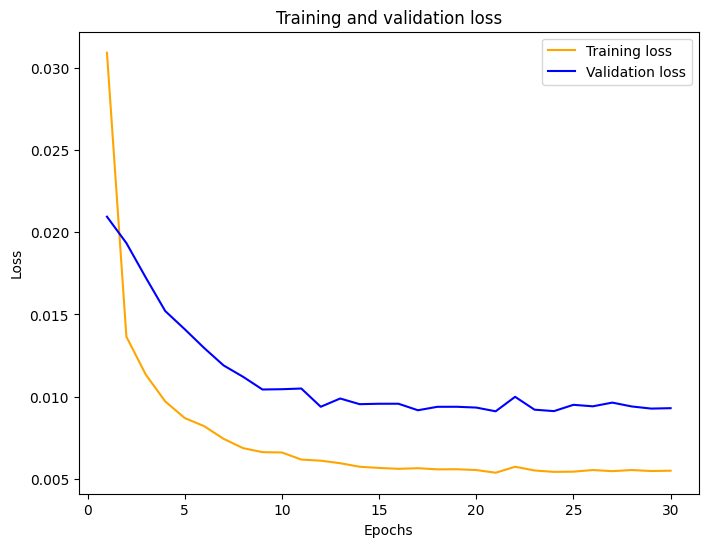

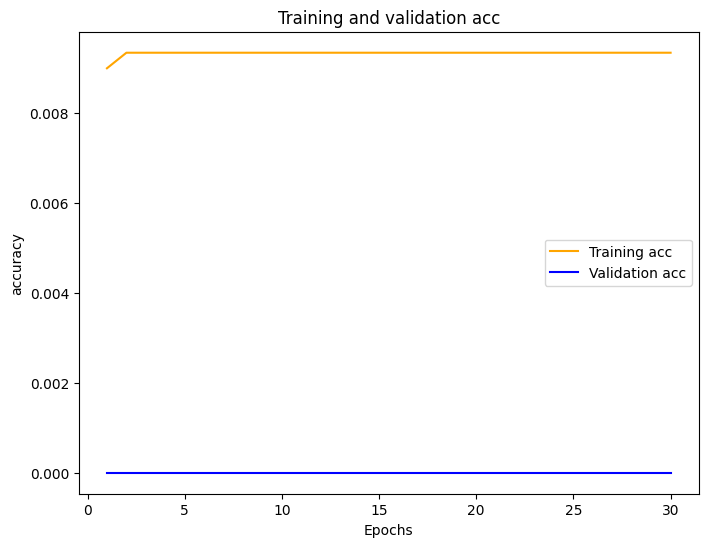

In [27]:
plot_curve(hist_2)

In [31]:
predict_scaled_2 = regressor_2.predict(X_test)
predict_2 = sc.inverse_transform(predict_scaled_2)
predict_2

2/2 [==============================] - 0s 10ms/step


array([[0.15513754],
       [0.1019703 ],
       [0.11077516],
       [0.12107174],
       [0.13486646],
       [0.16234885],
       [0.16842991],
       [0.16530108],
       [0.2041923 ],
       [0.27781615],
       [0.35666293],
       [0.33951774],
       [0.30947328],
       [0.26901823],
       [0.30669764],
       [0.33340093],
       [0.45332667],
       [0.32852235],
       [0.58403647],
       [0.71190244],
       [0.7421346 ],
       [0.79094994],
       [0.26887953],
       [0.21181738],
       [0.21098688],
       [0.17022666],
       [0.17814119],
       [0.16918531],
       [0.16820532],
       [0.15906164],
       [0.16051891],
       [0.15287498],
       [0.14148621],
       [0.13670163],
       [0.15977785],
       [0.17172265],
       [0.17651483],
       [0.17298578],
       [0.17773284],
       [0.17236374],
       [0.17490448],
       [0.17011334],
       [0.15239005],
       [0.16341175],
       [0.17559016],
       [0.18014787],
       [0.17911139],
       [0.172

In [32]:
test['LSTM_2'] = predict_2
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816


In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_2'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [35]:
lstm_mse_error_100_drop_out = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_2'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_2'])
print()
print(f'MSE Error: {lstm_mse_error_100_drop_out}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.009211764532251417
RMSE Error: 0.09597793773702068
MAE: 0.043177204623304564
r2_score: 0.5993765112533167


In [36]:
compare_mse_model(lstm_mse_error_unit_100,lstm_mse_error_100_drop_out)

,Model,MSE error
0,model,0.008906
1,model_1,0.009212


------------------------------------

## Add frist layer: units = 50 and change epochs from 30 to 50

In [39]:
regressor_3 = Sequential()
regressor_3.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_3.add(Dense(units = 1))
regressor_3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [40]:
hist_3 = regressor_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 50, batch_size = 32)

Epoch 1/50
91/91 [==============================] - 7s 34ms/step - loss: 0.0227 - accuracy: 0.0090 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 2/50
91/91 [==============================] - 2s 24ms/step - loss: 0.0109 - accuracy: 0.0093 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 3/50
91/91 [==============================] - 2s 22ms/step - loss: 0.0090 - accuracy: 0.0093 - val_loss: 0.0162 - val_accuracy: 0.0000e+00
Epoch 4/50
91/91 [==============================] - 2s 24ms/step - loss: 0.0076 - accuracy: 0.0093 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 5/50
91/91 [==============================] - 2s 22ms/step - loss: 0.0066 - accuracy: 0.0093 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 6/50
91/91 [==============================] - 2s 22ms/step - loss: 0.0062 - accuracy: 0.0093 - val_loss: 0.0110 - val_accuracy: 0.0000e+00
Epoch 7/50
91/91 [==============================] - 2s 21ms/step - loss: 0.0057 - accuracy: 0.0093 - val_loss: 0.0103 - val_accura

In [41]:
# regressor_3.save('lstm_test_one_day.h5')

Last train loss: 0.00482105603441596
Last validation loss: 0.009080370888113976


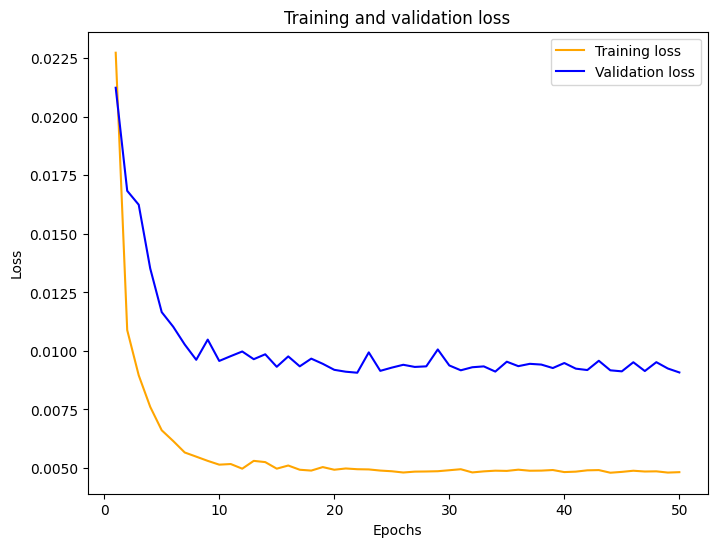

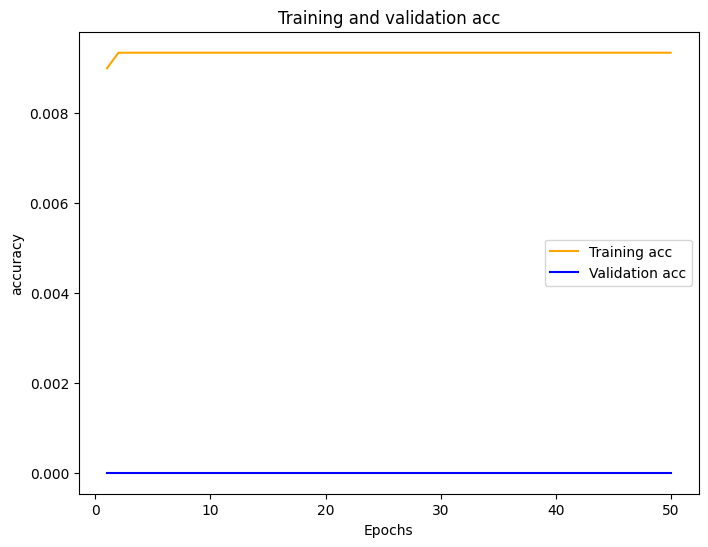

In [42]:
plot_curve(hist_3)

In [43]:
predict_scaled_3 = regressor_3.predict(X_test)
predict_scaled_3

2/2 [==============================] - 1s 8ms/step


array([[0.13467184],
       [0.09216993],
       [0.11045628],
       [0.12181921],
       [0.13688575],
       [0.16384296],
       [0.1641232 ],
       [0.15953016],
       [0.2003869 ],
       [0.27290002],
       [0.35000813],
       [0.3260053 ],
       [0.29574648],
       [0.2566832 ],
       [0.29980117],
       [0.3249665 ],
       [0.44971704],
       [0.31584355],
       [0.5859767 ],
       [0.7032349 ],
       [0.7358376 ],
       [0.7783359 ],
       [0.26201597],
       [0.20616637],
       [0.20007065],
       [0.16610833],
       [0.1764997 ],
       [0.16767865],
       [0.16816139],
       [0.157913  ],
       [0.15952612],
       [0.14914691],
       [0.1363339 ],
       [0.13202113],
       [0.15599638],
       [0.16423692],
       [0.16575462],
       [0.1612597 ],
       [0.16751409],
       [0.15991494],
       [0.16173805],
       [0.15537252],
       [0.13692248],
       [0.15187782],
       [0.16200744],
       [0.16806227],
       [0.1665414 ],
       [0.161

In [44]:
predict_3 = sc.inverse_transform(predict_scaled_3)
predict_3

array([[0.13899846],
       [0.09670909],
       [0.114904  ],
       [0.12621011],
       [0.14120132],
       [0.16802374],
       [0.16830258],
       [0.1637325 ],
       [0.20438495],
       [0.2765355 ],
       [0.35325807],
       [0.32937527],
       [0.29926774],
       [0.2603998 ],
       [0.30330217],
       [0.32834166],
       [0.45246845],
       [0.31926432],
       [0.58804685],
       [0.70471877],
       [0.7371584 ],
       [0.7794443 ],
       [0.26570588],
       [0.21013553],
       [0.20407028],
       [0.17027777],
       [0.18061718],
       [0.17184025],
       [0.17232057],
       [0.16212343],
       [0.16372849],
       [0.15340117],
       [0.14065222],
       [0.13636102],
       [0.16021639],
       [0.16841573],
       [0.16992584],
       [0.16545339],
       [0.1716765 ],
       [0.16411535],
       [0.16592936],
       [0.15959564],
       [0.14123785],
       [0.15611842],
       [0.16619739],
       [0.17222196],
       [0.17070869],
       [0.165

In [45]:
test['LSTM_3'] = predict_3
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138,0.138998
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970,0.096709
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775,0.114904
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072,0.126210
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866,0.141201
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349,0.168024
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430,0.168303
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301,0.163732
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192,0.204385
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816,0.276536


In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_3'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [47]:
lstm_mse_error_unit_100_epoch50 = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_3'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_3'])
print()
print(f'MSE Error: {lstm_mse_error_unit_100_epoch50}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.008989792132275097
RMSE Error: 0.0948145143544758
MAE: 0.04112777267653366
r2_score: 0.6090301836819425


In [48]:
compare_mse_model(lstm_mse_error_unit_100,lstm_mse_error_unit_100_epoch50)

,Model,MSE error
0,model,0.008906
1,model_1,0.008990


---

## Add frist layer: units = 100 and Add second layer: unit = 50 and epoch 30

In [52]:
regressor_4 = Sequential()
regressor_4.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_4.add(LSTM(units = 50))
regressor_4.add(Dense(units = 1))
regressor_4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [53]:
hist_4 = regressor_4.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 11s 52ms/step - loss: 0.0277 - accuracy: 0.0090 - val_loss: 0.0253 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 4s 41ms/step - loss: 0.0136 - accuracy: 0.0093 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 3s 34ms/step - loss: 0.0107 - accuracy: 0.0093 - val_loss: 0.0186 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 3s 36ms/step - loss: 0.0084 - accuracy: 0.0093 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 3s 35ms/step - loss: 0.0070 - accuracy: 0.0093 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 3s 35ms/step - loss: 0.0067 - accuracy: 0.0093 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 3s 36ms/step - loss: 0.0057 - accuracy: 0.0093 - val_loss: 0.0099 - val_accur

Last train loss: 0.005028841085731983
Last validation loss: 0.00891688372939825


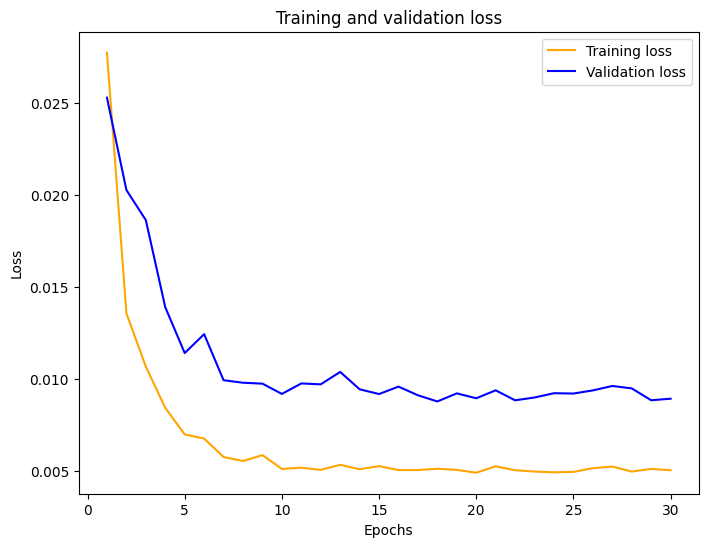

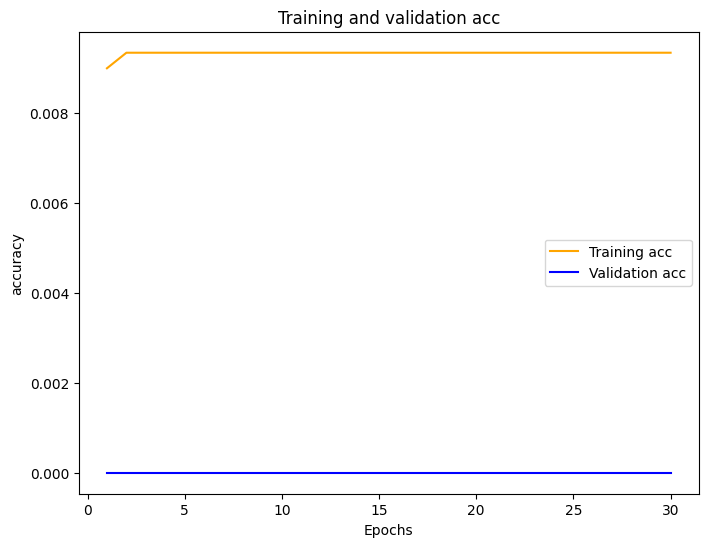

In [54]:
plot_curve(hist_4)

In [56]:
predict_scaled_4 = regressor_4.predict(X_test)
predict_4 = sc.inverse_transform(predict_scaled_4)
predict_4

2/2 [==============================] - 0s 11ms/step


array([[0.13039987],
       [0.08558927],
       [0.10093451],
       [0.11542243],
       [0.13089775],
       [0.15456396],
       [0.1590669 ],
       [0.15498026],
       [0.19210564],
       [0.26501542],
       [0.34452578],
       [0.32166573],
       [0.28905722],
       [0.245831  ],
       [0.2883112 ],
       [0.3161321 ],
       [0.442284  ],
       [0.30735162],
       [0.5724257 ],
       [0.6895279 ],
       [0.71902156],
       [0.75681156],
       [0.24072684],
       [0.17300123],
       [0.169961  ],
       [0.14324453],
       [0.1521891 ],
       [0.14708583],
       [0.15001819],
       [0.14015254],
       [0.14130856],
       [0.13297555],
       [0.12206763],
       [0.11913221],
       [0.14153127],
       [0.15095942],
       [0.15445247],
       [0.15302506],
       [0.1537812 ],
       [0.14873141],
       [0.15065807],
       [0.14467397],
       [0.13029604],
       [0.13800417],
       [0.15041363],
       [0.15449993],
       [0.15611187],
       [0.151

In [57]:
test['LSTM_4'] = predict_4
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3,LSTM_4
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138,0.138998,0.130400
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970,0.096709,0.085589
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775,0.114904,0.100935
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072,0.126210,0.115422
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866,0.141201,0.130898
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349,0.168024,0.154564
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430,0.168303,0.159067
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301,0.163732,0.154980
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192,0.204385,0.192106
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816,0.276536,0.265015


In [59]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_4'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [60]:
lstm_mse_error_second_layer = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_4'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_4'])
print()
print(f'MSE Error: {lstm_mse_error_second_layer}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.008827937040913354
RMSE Error: 0.09395710213130966
MAE: 0.04208881088577468
r2_score: 0.6160693292382289


In [61]:
compare_mse_model(lstm_mse_error_unit_100,lstm_mse_error_second_layer)

,Model,MSE error
0,model,0.008906
1,model_1,0.008828


---

## Add frist layer: units = 100 and Add second layer: unit = 100 and epoch 30

In [62]:
regressor_5 = Sequential()
regressor_5.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_5.add(LSTM(units = 100))
regressor_5.add(Dense(units = 1))
regressor_5.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [63]:
hist_5 = regressor_5.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 14s 77ms/step - loss: 0.0353 - accuracy: 0.0086 - val_loss: 0.0235 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 6s 65ms/step - loss: 0.0137 - accuracy: 0.0093 - val_loss: 0.0221 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 7s 73ms/step - loss: 0.0105 - accuracy: 0.0093 - val_loss: 0.0159 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 5s 58ms/step - loss: 0.0082 - accuracy: 0.0093 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 5s 50ms/step - loss: 0.0070 - accuracy: 0.0093 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 5s 56ms/step - loss: 0.0061 - accuracy: 0.0093 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 4s 46ms/step - loss: 0.0056 - accuracy: 0.0093 - val_loss: 0.0128 - val_accur

Last train loss: 0.004920026753097773
Last validation loss: 0.00925711914896965


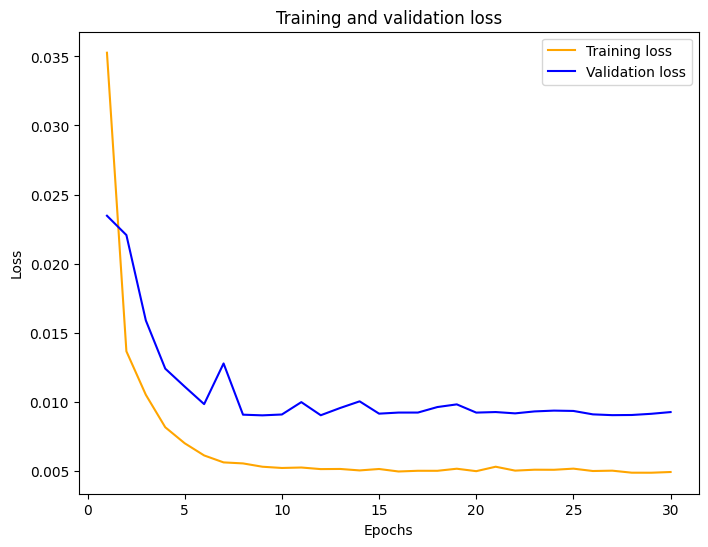

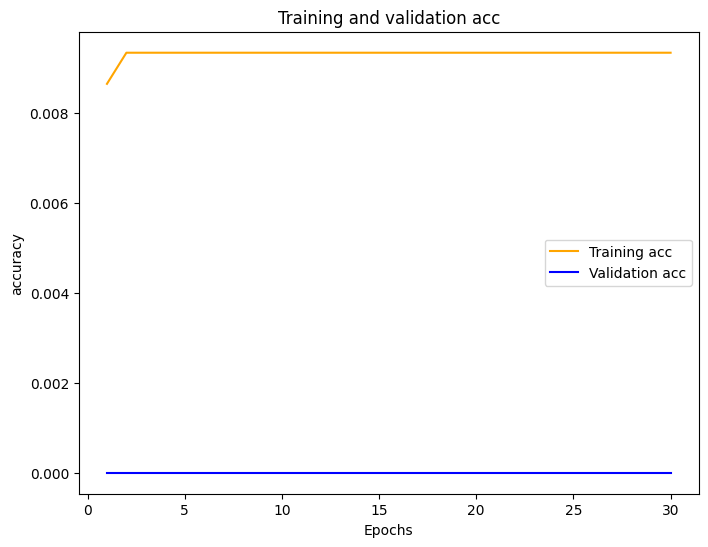

In [64]:
plot_curve(hist_5)

In [65]:
predict_scaled_5 = regressor_5.predict(X_test)
predict_5 = sc.inverse_transform(predict_scaled_5)
predict_5

2/2 [==============================] - 2s 11ms/step


array([[0.10558042],
       [0.06359448],
       [0.07866371],
       [0.09518335],
       [0.11729681],
       [0.1406294 ],
       [0.1467734 ],
       [0.14563565],
       [0.1818289 ],
       [0.25291649],
       [0.33197215],
       [0.31193826],
       [0.28066376],
       [0.23855558],
       [0.27704784],
       [0.302234  ],
       [0.42318568],
       [0.29678282],
       [0.550039  ],
       [0.67668396],
       [0.7129699 ],
       [0.7486266 ],
       [0.23559597],
       [0.17180125],
       [0.16786903],
       [0.13591138],
       [0.14530292],
       [0.14182787],
       [0.14526436],
       [0.13810723],
       [0.1400368 ],
       [0.13204417],
       [0.12004582],
       [0.11535391],
       [0.13736373],
       [0.14725007],
       [0.1504598 ],
       [0.14880227],
       [0.15187818],
       [0.14623751],
       [0.1477121 ],
       [0.14125746],
       [0.12538636],
       [0.13460766],
       [0.14632595],
       [0.15125898],
       [0.15113652],
       [0.145

In [66]:
test['LSTM_5'] = predict_5
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138,0.138998,0.130400,0.105580
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970,0.096709,0.085589,0.063594
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775,0.114904,0.100935,0.078664
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072,0.126210,0.115422,0.095183
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866,0.141201,0.130898,0.117297
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349,0.168024,0.154564,0.140629
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430,0.168303,0.159067,0.146773
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301,0.163732,0.154980,0.145636
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192,0.204385,0.192106,0.181829
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816,0.276536,0.265015,0.252916


In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_5'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [68]:
lstm_mse_error_second_layer100 = mean_squared_error(test['cloud_cover'], test['LSTM_5'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_5'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_5'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_5'])
print()
print(f'MSE Error: {lstm_mse_error_second_layer100}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.009164778426073248
RMSE Error: 0.09573284925287269
MAE: 0.046603202862986214
r2_score: 0.6014199566446765


In [69]:
compare_mse_model(lstm_mse_error_second_layer,lstm_mse_error_second_layer100)

,Model,MSE error
0,model,0.008828
1,model_1,0.009165


## Add frist layer: units = 100 and Add second layer: unit = 50 and epoch 50

In [70]:
regressor_6 = Sequential()
regressor_6.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_6.add(LSTM(units = 50))
regressor_6.add(Dense(units = 1))
regressor_6.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [71]:
hist_6 = regressor_6.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 50, batch_size = 32)

Epoch 1/50
91/91 [==============================] - 11s 55ms/step - loss: 0.0356 - accuracy: 0.0090 - val_loss: 0.0231 - val_accuracy: 0.0000e+00
Epoch 2/50
91/91 [==============================] - 4s 40ms/step - loss: 0.0138 - accuracy: 0.0093 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 3/50
91/91 [==============================] - 4s 41ms/step - loss: 0.0112 - accuracy: 0.0093 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 4/50
91/91 [==============================] - 4s 40ms/step - loss: 0.0089 - accuracy: 0.0093 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 5/50
91/91 [==============================] - 3s 37ms/step - loss: 0.0077 - accuracy: 0.0093 - val_loss: 0.0123 - val_accuracy: 0.0000e+00
Epoch 6/50
91/91 [==============================] - 4s 44ms/step - loss: 0.0064 - accuracy: 0.0093 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 7/50
91/91 [==============================] - 4s 49ms/step - loss: 0.0058 - accuracy: 0.0093 - val_loss: 0.0117 - val_accur

Last train loss: 0.0050884741358459
Last validation loss: 0.008918199688196182


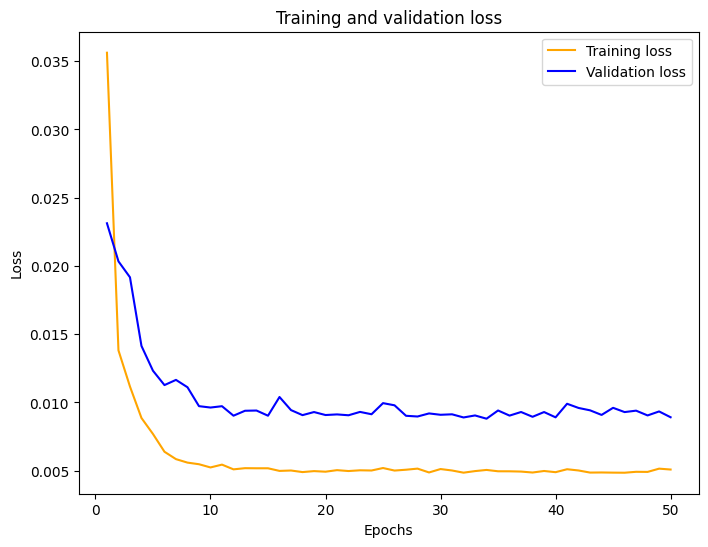

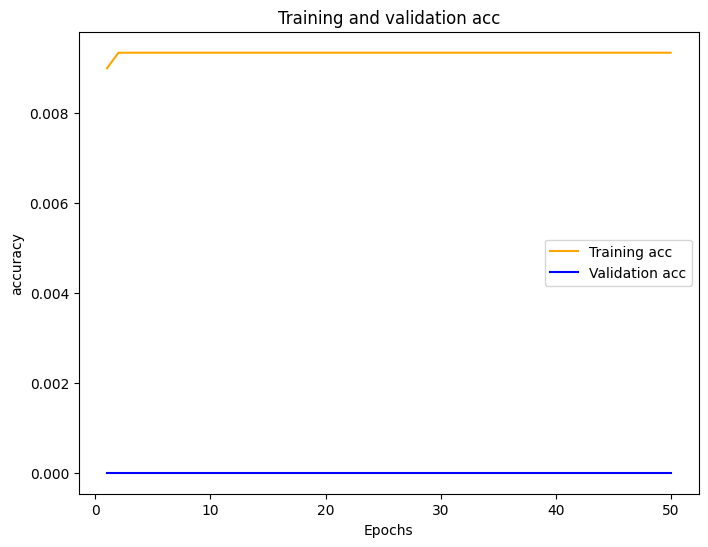

In [72]:
plot_curve(hist_6)

In [73]:
predict_scaled_6 = regressor_6.predict(X_test)
predict_6 = sc.inverse_transform(predict_scaled_6)
predict_6

2/2 [==============================] - 1s 10ms/step


array([[0.13742267],
       [0.09474087],
       [0.11036778],
       [0.12347215],
       [0.13714117],
       [0.15951513],
       [0.16252923],
       [0.15817073],
       [0.19531627],
       [0.26649645],
       [0.34346312],
       [0.32316467],
       [0.29244813],
       [0.2538492 ],
       [0.2938015 ],
       [0.31947067],
       [0.436273  ],
       [0.31449673],
       [0.55832434],
       [0.680225  ],
       [0.717725  ],
       [0.75299835],
       [0.2876393 ],
       [0.2047007 ],
       [0.19499145],
       [0.16376676],
       [0.16832589],
       [0.16091809],
       [0.15915042],
       [0.14753498],
       [0.14642146],
       [0.1373267 ],
       [0.12576762],
       [0.12090566],
       [0.14012975],
       [0.14891551],
       [0.1523948 ],
       [0.14828989],
       [0.15098247],
       [0.14610411],
       [0.14780444],
       [0.14323077],
       [0.12742351],
       [0.1362033 ],
       [0.14660737],
       [0.15240298],
       [0.15342991],
       [0.149

In [74]:
test['LSTM_6'] = predict_6
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5,LSTM_6
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138,0.138998,0.130400,0.105580,0.137423
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970,0.096709,0.085589,0.063594,0.094741
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775,0.114904,0.100935,0.078664,0.110368
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072,0.126210,0.115422,0.095183,0.123472
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866,0.141201,0.130898,0.117297,0.137141
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349,0.168024,0.154564,0.140629,0.159515
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430,0.168303,0.159067,0.146773,0.162529
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301,0.163732,0.154980,0.145636,0.158171
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192,0.204385,0.192106,0.181829,0.195316
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816,0.276536,0.265015,0.252916,0.266496


In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_6'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [76]:
lstm_mse_error_second_layer_epoch6 = mean_squared_error(test['cloud_cover'], test['LSTM_6'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_6'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_6'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_6'])
print()
print(f'MSE Error: {lstm_mse_error_second_layer_epoch6}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.008829241075671252
RMSE Error: 0.09396404139707515
MAE: 0.04335421318124082
r2_score: 0.6160126162217023


In [77]:
compare_mse_model(lstm_mse_error_second_layer,lstm_mse_error_second_layer_epoch6)

,Model,MSE error
0,model,0.008828
1,model_1,0.008829


## Add frist layer: units = 100 and Add second layer: unit = 50 and epoch 30 and add thrid layer: unit 50

In [78]:
regressor_7 = Sequential()
regressor_7.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor_7.add(LSTM(units = 50, return_sequences = True))
regressor_7.add(LSTM(units = 50))
regressor_7.add(Dense(units = 1))
regressor_7.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [79]:
hist_7 = regressor_7.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 30, batch_size = 32)

Epoch 1/30
91/91 [==============================] - 23s 98ms/step - loss: 0.0387 - accuracy: 0.0090 - val_loss: 0.0330 - val_accuracy: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 6s 64ms/step - loss: 0.0183 - accuracy: 0.0093 - val_loss: 0.0251 - val_accuracy: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 6s 67ms/step - loss: 0.0137 - accuracy: 0.0093 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 4/30
91/91 [==============================] - 5s 51ms/step - loss: 0.0107 - accuracy: 0.0093 - val_loss: 0.0160 - val_accuracy: 0.0000e+00
Epoch 5/30
91/91 [==============================] - 5s 56ms/step - loss: 0.0087 - accuracy: 0.0093 - val_loss: 0.0149 - val_accuracy: 0.0000e+00
Epoch 6/30
91/91 [==============================] - 4s 47ms/step - loss: 0.0064 - accuracy: 0.0093 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 7/30
91/91 [==============================] - 4s 46ms/step - loss: 0.0056 - accuracy: 0.0093 - val_loss: 0.0109 - val_accur

Last train loss: 0.005072260275483131
Last validation loss: 0.009763576090335846


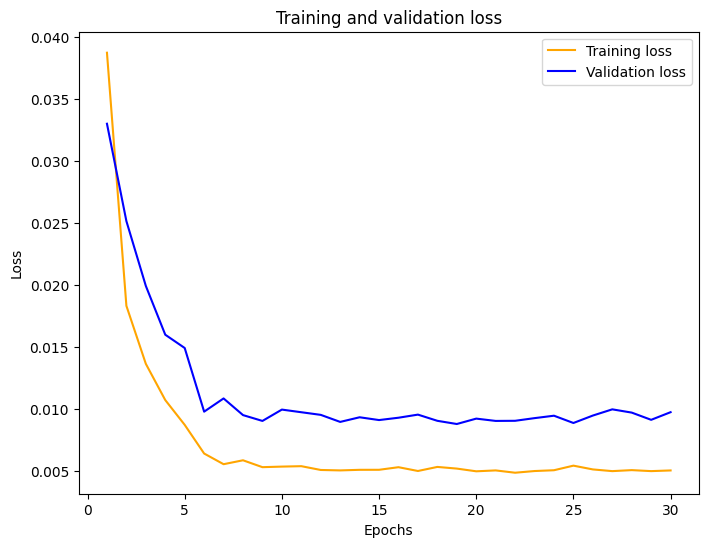

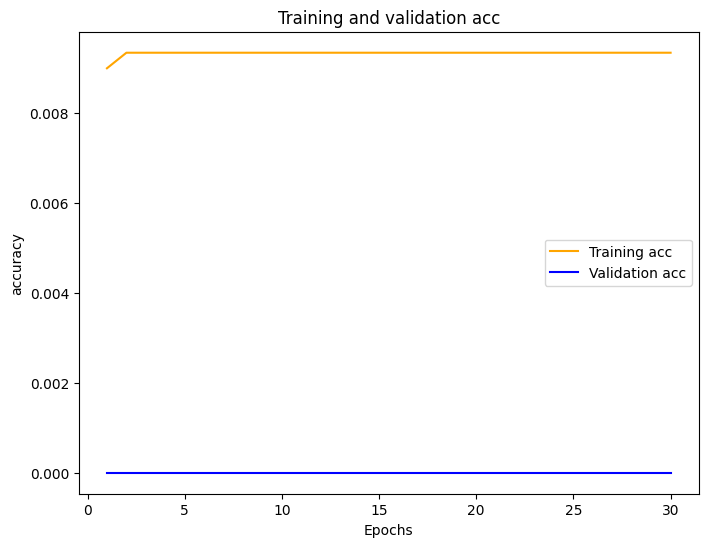

In [80]:
plot_curve(hist_7)

In [81]:
predict_scaled_7 = regressor_7.predict(X_test)
predict_7 = sc.inverse_transform(predict_scaled_7)
predict_7

2/2 [==============================] - 2s 25ms/step


array([[0.11621349],
       [0.08447098],
       [0.09567846],
       [0.11056804],
       [0.128708  ],
       [0.15488592],
       [0.1579595 ],
       [0.15355219],
       [0.19105321],
       [0.26383325],
       [0.34477893],
       [0.32131374],
       [0.2916657 ],
       [0.25413752],
       [0.29752406],
       [0.326462  ],
       [0.45258865],
       [0.32260746],
       [0.5849991 ],
       [0.7109209 ],
       [0.74253   ],
       [0.7849995 ],
       [0.27802512],
       [0.247108  ],
       [0.23342787],
       [0.20253195],
       [0.20647478],
       [0.19934899],
       [0.19628635],
       [0.1854185 ],
       [0.18319145],
       [0.17266923],
       [0.15853219],
       [0.15146215],
       [0.17043233],
       [0.1797242 ],
       [0.1820604 ],
       [0.17936316],
       [0.18279853],
       [0.17799981],
       [0.18022463],
       [0.17489058],
       [0.1602591 ],
       [0.16980924],
       [0.18143289],
       [0.18726021],
       [0.1879568 ],
       [0.183

In [82]:
test['LSTM_7'] = predict_7
test

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5,LSTM_6,LSTM_7
0,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.149500,0.148911,0.155138,0.138998,0.130400,0.105580,0.137423,0.116213
1,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.099744,0.103276,0.101970,0.096709,0.085589,0.063594,0.094741,0.084471
2,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.110436,0.117531,0.110775,0.114904,0.100935,0.078664,0.110368,0.095678
3,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.119723,0.126066,0.121072,0.126210,0.115422,0.095183,0.123472,0.110568
4,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.134598,0.138684,0.134866,0.141201,0.130898,0.117297,0.137141,0.128708
5,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.159302,0.165257,0.162349,0.168024,0.154564,0.140629,0.159515,0.154886
6,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.161752,0.164147,0.168430,0.168303,0.159067,0.146773,0.162529,0.157960
7,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158447,0.158934,0.165301,0.163732,0.154980,0.145636,0.158171,0.153552
8,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.197410,0.199241,0.204192,0.204385,0.192106,0.181829,0.195316,0.191053
9,2021-12-16 10:00:00,618.4746,27.8648,52.1288,1.7808,0.361,0.268113,0.268316,0.277816,0.276536,0.265015,0.252916,0.266496,0.263833


In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['timestamp'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['timestamp'], y = test['LSTM_7'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [84]:
lstm_mse_error_thrid_layer = mean_squared_error(test['cloud_cover'], test['LSTM_7'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_7'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_7'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_7'])
print()
print(f'MSE Error: {lstm_mse_error_thrid_layer}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.009666186179167728
RMSE Error: 0.09831676448687542
MAE: 0.051534779191017156
r2_score: 0.5796135239437474


In [85]:
compare_mse_model(lstm_mse_error_second_layer,lstm_mse_error_thrid_layer)

,Model,MSE error
0,model,0.008828
1,model_1,0.009666


---